# FACEBOOK DATA FROM YAHOO FINANCE

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("C:/Users/ASUS/Desktop/FMI/Licenta OB/Overall Code/packtpub-notebooks/packtpub-src/csv/FB2012-2019.csv")

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-05-29,31.480000,31.690001,28.650000,28.840000,28.840000,78063400
1,2012-05-30,28.700001,29.549999,27.860001,28.190001,28.190001,57267900
2,2012-05-31,28.549999,29.670000,26.830000,29.600000,29.600000,111639200
3,2012-06-01,28.889999,29.150000,27.389999,27.719999,27.719999,41855500
4,2012-06-04,27.200001,27.650000,26.440001,26.900000,26.900000,35230300


In [4]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1755,2019-05-21,184.570007,185.699997,183.889999,184.820007,184.820007,7502800
1756,2019-05-22,184.729996,186.740005,183.610001,185.320007,185.320007,9213800
1757,2019-05-23,182.419998,183.899994,179.669998,180.869995,180.869995,12768800
1758,2019-05-24,182.330002,183.630005,180.830002,181.059998,181.059998,8807700
1759,2019-05-28,181.539993,184.710007,181.449997,184.309998,184.309998,14843300


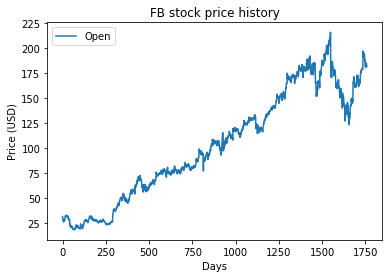

In [5]:
plt.figure()
plt.title("FB stock price history")
plt.plot(df['Open'])
#plt.plot(df["Close"])
#plt.plot(df["High"])
#plt.plot(df["Low"])
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open', 'Close', 'High', 'Low'], loc='upper left')
plt.show()

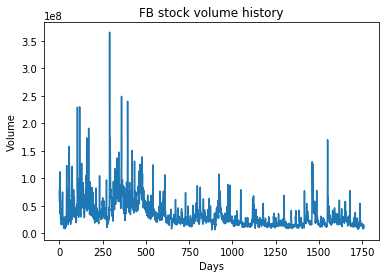

In [6]:
plt.figure()
plt.plot(df['Volume'])
plt.title('FB stock volume history')
plt.ylabel('Volume')
plt.xlabel('Days')
plt.show()

In [7]:
print('Checking if any null values are present\n', df.isna().sum())

Checking if any null values are present
 Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


### Normalizing the data
* Split the data into train, test
* Normalize
* Covert the DataFrame to ndarray

In [8]:
#! pip install keras

In [9]:
#! pip install np_utils

In [10]:
#! pip install tensorflow

In [11]:
#! pip install numpy --upgrade --user

In [12]:
from tqdm._tqdm_notebook import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras import optimizers
from keras import backend as K
from keras.callbacks import EarlyStopping

print('Checking GPU available', K.tensorflow_backend._get_available_gpus())


Using TensorFlow backend.


Checking GPU available []


In [13]:
from keras import losses

In [14]:
TIME_STEPS = 60
BATCH_SIZE = 20

In [15]:
params = {
    "batch_size": 20,  # 20<16<10, 25 was a bust
    "epochs": 300,
    "lr": 0.00010000,
    "time_steps": 60
}

In [16]:

train_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
df_train, df_test = train_test_split(df, train_size=0.8, test_size=0.2, shuffle=False)
print('Train and test set', len(df_train), len(df_test))

#scale the feature MinMax, build array
x = df_train.loc[:, train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:, train_cols])

Train and test set 1408 352


In [17]:
def build_timeseries(mat, y_col_index):
    # y_col_index is the index of column that would act as output column
    # total nb of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    
    print('length of time-series i/o', x.shape, y.shape)
    return x, y

In [18]:
def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that is divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0] % batch_size
    if no_of_rows_drop > 0:
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [19]:
x_t, y_t = build_timeseries(x_train, 3)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)

x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE), 2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE), 2)


length of time-series i/o (1348, 60, 5) (1348,)



length of time-series i/o (292, 60, 5) (292,)


In [20]:
def create_model():
    lstm_model = Sequential()
    # (batch_size, time_steps, data_dim)
    lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]),
                       dropout=0.0, recurrent_dropout=0.0, stateful=True, return_sequences=True,
                       kernel_initializer='random_uniform'))
    lstm_model.add(Dropout(0.4))
    lstm_model.add(LSTM(60, dropout=0.0))
    lstm_model.add(Dropout(0.4))
    lstm_model.add(Dense(20, activation='relu'))
    lstm_model.add(Dense(1, activation='linear'))
    optimizer = optimizers.RMSprop(lr=params['lr'])
    lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)
    # lstm_model.compile(loss=losses.mean_squarred_error, optimizer=optimizer)
    return lstm_model

In [21]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                   patience=40, min_delta=0.0001)

In [22]:
model = create_model()

#csv_logger = CSVLogger()

history = model.fit(x_t, y_t, epochs=params['epochs'], verbose=2, batch_size=BATCH_SIZE,
                   shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE), 
                                                   trim_dataset(y_val, BATCH_SIZE)),callbacks=[es])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 1340 samples, validate on 140 samples
Epoch 1/300
 - 8s - loss: 0.0129 - val_loss: 0.0061
Epoch 2/300
 - 6s - loss: 0.0100 - val_loss: 0.0050
Epoch 3/300
 - 6s - loss: 0.0081 - val_loss: 0.0104
Epoch 4/300
 - 5s - loss: 0.0072 - val_loss: 0.0053
Epoch 5/300
 - 6s - loss: 0.0055 - val_loss: 0.0046
Epoch 6/300
 - 5s - loss: 0.0052 - val_loss: 0.0040
Epoch 7/300
 - 5s - loss: 0.0054 - val_loss: 0.0071
Epoch 8/300
 - 5s - loss: 0.0051 - val_loss: 0.0040
Epoch 9/300
 - 5s - loss: 0.0049 - val_loss: 0.0056
Epoch 10/300
 - 5s - loss: 0.0045 - val_loss: 0.0038
Epoch 11/300
 - 5s - loss: 0.0045 - val_loss: 0.0040
Epoch 12/300
 - 5s - loss: 0.0040 - val_loss: 0.0041
Epoch 13/300
 - 6s - loss: 0.0036 - val_loss: 0.0040
Epoch 14/300
 - 6s - loss: 0.0038 - va

Epoch 137/300
 - 5s - loss: 0.0013 - val_loss: 0.0037
Epoch 138/300
 - 5s - loss: 0.0012 - val_loss: 0.0067
Epoch 139/300
 - 5s - loss: 0.0014 - val_loss: 0.0045
Epoch 140/300
 - 5s - loss: 0.0013 - val_loss: 0.0029
Epoch 141/300
 - 5s - loss: 0.0013 - val_loss: 0.0033
Epoch 142/300
 - 5s - loss: 0.0012 - val_loss: 0.0043
Epoch 143/300
 - 5s - loss: 0.0012 - val_loss: 0.0069
Epoch 144/300
 - 5s - loss: 0.0013 - val_loss: 0.0039
Epoch 145/300
 - 5s - loss: 0.0013 - val_loss: 0.0038
Epoch 146/300
 - 5s - loss: 0.0012 - val_loss: 0.0069
Epoch 147/300
 - 5s - loss: 0.0013 - val_loss: 0.0026
Epoch 148/300
 - 5s - loss: 0.0012 - val_loss: 0.0069
Epoch 149/300
 - 5s - loss: 0.0012 - val_loss: 0.0045
Epoch 150/300
 - 5s - loss: 0.0013 - val_loss: 0.0040
Epoch 151/300
 - 5s - loss: 0.0013 - val_loss: 0.0030
Epoch 152/300
 - 5s - loss: 0.0012 - val_loss: 0.0046
Epoch 153/300
 - 5s - loss: 0.0013 - val_loss: 0.0043
Epoch 154/300
 - 5s - loss: 0.0011 - val_loss: 0.0027
Epoch 155/300
 - 5s - loss: 

In [23]:
x_t.shape

(1340, 60, 5)

In [24]:
# save model
import pickle

filename = 'lstm_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [25]:
# load the model
loaded_model = pickle.load(open(filename, 'rb'))


In [26]:
print(history.history.keys())
print(history.history['val_loss'])

dict_keys(['val_loss', 'loss'])
[0.006054274172389081, 0.005049986498696464, 0.010401403211290017, 0.005260756422233369, 0.00464085177684735, 0.004034878054101553, 0.007109419268090278, 0.004003740581018584, 0.005602758053490626, 0.003803864005021751, 0.004016687087382057, 0.0041015627211891115, 0.003955297945399902, 0.003614766223888312, 0.006713343434967101, 0.004475777137226292, 0.0037227093541462508, 0.0040997370961122215, 0.0056552834160226795, 0.003473109332844615, 0.004229641070456377, 0.0034170799356486115, 0.005123185575939715, 0.0037139313228960547, 0.005517838472899582, 0.0042194565342340085, 0.005541551517256137, 0.004057793786549675, 0.003520464458103691, 0.00393677143646138, 0.003419340305429484, 0.0041822473618334955, 0.004379705517619316, 0.006916209365174707, 0.006195234151424042, 0.004908272339629808, 0.003476652948717986, 0.0044288973856185165, 0.0036570168782158624, 0.006165497113085751, 0.004604840243700892, 0.0052396352236558285, 0.004010704088224364, 0.0032247770

Text(0, 0.5, 'Model loss')

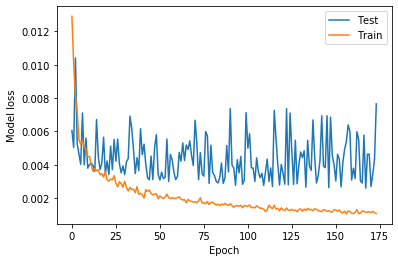

In [27]:
plt.figure()
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.legend(['Test', 'Train'])
plt.xlabel('Epoch')
plt.ylabel('Model loss')

In [28]:
# plot the predicted vs real price

LSTM

In [29]:
y_pred = model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error", error, y_pred.shape, y_test_t.shape)

y_pred_orig = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] #min_max_scaler.inverse_transform(y_pred)
y_test_t_orig = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] #min_max_scaler.inverse_transform(y_test_t)

Error 0.004368355701955423 (140,) (140,)


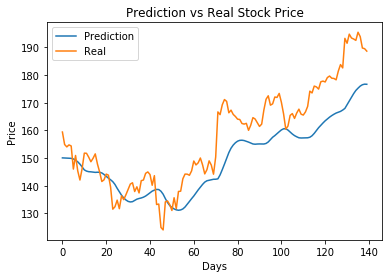

In [31]:
plt.figure()
plt.plot(y_pred_orig)
plt.plot(y_test_t_orig)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
plt.show()

In [32]:
# do gridsearch, put logging into
# what overfit would mean here?
# read lstm AK
# how to appreciate how good is the prediction?

# sentiment analysis for stock prediction ? X

# ! when u use lstm, y is the close price of that they
# on another model I think you kept the close price of that they

In [33]:
print(type(y_test_t_orig))
print(y_test_t_orig.shape)

<class 'numpy.ndarray'>
(140,)


# STRATEGY


    http://cs229.stanford.edu/proj2017/final-reports/5241098.pdf

We consider a simple algorithmic trading strategy based
on the prediction by the model. At day t, an investor buys
one share of INTC stock if the predicted price is higher
than the current actual adjusted closing price. Otherwise,
he or she sells one share of INTC stock. The strategy st
can be described as:
st =
(
+1 if yˆt+1 > yt
−1 if yˆt+1 ≤ yt

In [34]:
y_pred # prediction
pass

In [35]:
x_test_t # window
pass

In [36]:
# x_t : train data
# x_val: validation data
# x_test_t: test data

TODO
1. get data OK
2. write trading algorithm (function of the prediction) OK
3. compute returns

4. compute sharpe ratio of the strategy

In [37]:
y_pred_orig # predicted data
pass

In [38]:
y_test_t_orig # real data
pass

In [39]:
predicted_data = y_pred_orig
real_data = y_test_t_orig

In [40]:
len(predicted_data) == len(real_data)

True

In [41]:
assert len(predicted_data) == len(real_data)
type(predicted_data), type(predicted_data[0])

(numpy.ndarray, numpy.float32)

In [42]:
class strategy():
    def __init__(self):
        self.stocks = 0
    
    def take_action(self, today_real_price, tomorrow_forcasted_price):
        """
         At day t, an investor buys one share of INTC stock if the predicted price 
         is higher than the current actual adjusted closing price.
         Otherwise, he or she sells one share of INTC stock"""
        if tomorrow_forcasted_price > today_real_price:
            self.stocks += 1
        else:
            self.stocks -= 1
    
    def compute_daily_return(self, today_real_price, tomorrow_real_price):
        """
         Using the
indicator variable st
, we can calculate a daily return of
the strategy at day t + 1:
rt+1 = st × log 
yt+1
yt

−
        """
        import math
        daily_return = self.stocks * math.log(tomorrow_real_price, today_real_price)
        return daily_return
            

In [43]:
def execute_strategy(strategy, predicted_data, verbose=True):
    """
    args: strategy to execute
    """
    cumulative_return = 0
    for day, today_real_price in enumerate(real_data[:-1]):
        # day by day and execute my strategy
        today_predicted_price = predicted_data[day]
        if verbose: print(day, today_real_price, today_predicted_price)
        
        strategy.take_action(today_real_price, predicted_data[day + 1])
        today_return = strategy.compute_daily_return(today_real_price, real_data[day + 1])
        # metric: cumulative return
        # sum of all the returns
        cumulative_return += today_return
    return cumulative_return

In [44]:
lstm_strategy = strategy() # you need initialize this every time
lstm_predicted_data = y_pred_orig # find prediction data

real_data = y_test_t_orig

lstm_strategy_return = execute_strategy(lstm_strategy, lstm_predicted_data, verbose=False)
lstm_strategy.stocks # how is my stock balance at the end of the execution:?
print(lstm_strategy_return)

-6373.165115511636


In [45]:
regressor_strategy = strategy()
regression_predicted_data = y_pred_orig # TODO: find this
real_data = y_test_t_orig
regression_strategy_return = execute_strategy(regressor_strategy, regression_predicted_data, verbose=False)
regressor_strategy.stocks
print(regression_strategy_return)

-6373.165115511636


##Directional Accuracy

In [ ]:
def directional_accuracy(predicted_data, real_data):
    """return the nb of days that the model got the movement right / nb of days in total
    args:
        predicted_data:
    """
    